<a href="https://www.kaggle.com/code/okolinnamdinnaemeka/zomato-geospatial-analysis?scriptVersionId=150264911" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zomato-rawdata/zomato_rawdata.sqlite


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import nltk
from nltk.corpus import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams , trigrams
from geopy.geocoders import Nominatim
import folium
from folium.plugins import HeatMap

import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
con = sqlite3.connect(r'/kaggle/input/zomato-rawdata/zomato_rawdata.sqlite')
df = pd.read_sql_query('SELECT * from Users' , con)

df.head()

,index,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [4]:
df.shape

(51717, 18)

In [5]:
df.columns

Index(['index', 'url', 'address', 'name', 'online_order', 'book_table', 'rate',
       'votes', 'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

Checking for missing values

In [6]:
df.isnull().sum()

index                              0
url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [7]:
df.isnull().sum()/len(df)*100

index                           0.000000
url                             0.000000
address                         0.000000
name                            0.000000
online_order                    0.000000
book_table                      0.000000
rate                           15.033741
votes                           0.000000
phone                           2.335789
location                        0.040606
rest_type                       0.438927
dish_liked                     54.291626
cuisines                        0.087012
approx_cost(for two people)     0.669026
reviews_list                    0.000000
menu_item                       0.000000
listed_in(type)                 0.000000
listed_in(city)                 0.000000
dtype: float64

In [8]:
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', 'NEW', '2.9/5', '3.5/5', None, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '-', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [9]:
df['rate'].replace(('NEW', '-'), np.nan, inplace= True)
df['rate'].unique()

array(['4.1/5', '3.8/5', '3.7/5', '3.6/5', '4.6/5', '4.0/5', '4.2/5',
       '3.9/5', '3.1/5', '3.0/5', '3.2/5', '3.3/5', '2.8/5', '4.4/5',
       '4.3/5', nan, '2.9/5', '3.5/5', None, '2.6/5', '3.8 /5', '3.4/5',
       '4.5/5', '2.5/5', '2.7/5', '4.7/5', '2.4/5', '2.2/5', '2.3/5',
       '3.4 /5', '3.6 /5', '4.8/5', '3.9 /5', '4.2 /5', '4.0 /5',
       '4.1 /5', '3.7 /5', '3.1 /5', '2.9 /5', '3.3 /5', '2.8 /5',
       '3.5 /5', '2.7 /5', '2.5 /5', '3.2 /5', '2.6 /5', '4.5 /5',
       '4.3 /5', '4.4 /5', '4.9/5', '2.1/5', '2.0/5', '1.8/5', '4.6 /5',
       '4.9 /5', '3.0 /5', '4.8 /5', '2.3 /5', '4.7 /5', '2.4 /5',
       '2.1 /5', '2.2 /5', '2.0 /5', '1.8 /5'], dtype=object)

In [10]:
'4.2/5'.split('/')[0]

'4.2'

In [11]:
type('4.2/5'.split('/')[0])

str

In [12]:
float('4.2/5'.split('/')[0])

4.2

In [13]:
df['rate'] = df['rate'].apply(lambda x : float(x.split('/')[0]) if type(x)==str else x)
df['rate']

0        4.1
1        4.1
2        3.8
3        3.7
4        3.8
        ... 
51712    3.6
51713    NaN
51714    NaN
51715    4.3
51716    3.4
Name: rate, Length: 51717, dtype: float64

In [14]:
df.head(2)

,index,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari


# Relation between online order and rating

In [15]:
x = pd.crosstab(df['rate'] , df['online_order'])
x

online_order,No,Yes
rate,,
1.8,5,0
2.0,11,0
2.1,9,15
2.2,10,16
2.3,29,22
2.4,36,34
2.5,38,63
2.6,83,177
2.7,141,166


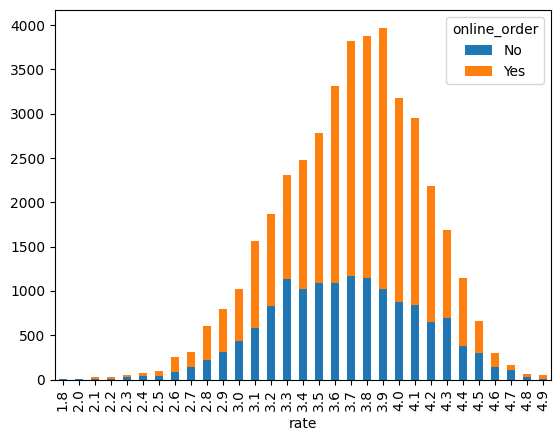

In [16]:
x.plot(kind = 'bar' , stacked= True)
sns.set_style("white")

# Text Cleaning

In [17]:
df['rest_type'].isnull().sum()

227

In [18]:
data = df.dropna(subset = ['rest_type'])

In [19]:
data['rest_type'].isnull().sum()

0

In [20]:
data['rest_type'].unique()

array(['Casual Dining', 'Cafe, Casual Dining', 'Quick Bites',
       'Casual Dining, Cafe', 'Cafe', 'Quick Bites, Cafe',
       'Cafe, Quick Bites', 'Delivery', 'Mess', 'Dessert Parlor',
       'Bakery, Dessert Parlor', 'Pub', 'Bakery', 'Takeaway, Delivery',
       'Fine Dining', 'Beverage Shop', 'Sweet Shop', 'Bar',
       'Beverage Shop, Quick Bites', 'Confectionery',
       'Quick Bites, Beverage Shop', 'Dessert Parlor, Sweet Shop',
       'Bakery, Quick Bites', 'Sweet Shop, Quick Bites', 'Kiosk',
       'Food Truck', 'Quick Bites, Dessert Parlor',
       'Beverage Shop, Dessert Parlor', 'Takeaway', 'Pub, Casual Dining',
       'Casual Dining, Bar', 'Dessert Parlor, Beverage Shop',
       'Quick Bites, Bakery', 'Dessert Parlor, Quick Bites',
       'Microbrewery, Casual Dining', 'Lounge', 'Bar, Casual Dining',
       'Food Court', 'Cafe, Bakery', 'Dhaba', 'Quick Bites, Sweet Shop',
       'Microbrewery', 'Food Court, Quick Bites', 'Pub, Bar',
       'Casual Dining, Pub', 'Lounge, Ba

In [21]:
quick_bites_df = data[data['rest_type'].str.contains('Quick Bites')]
quick_bites_df.columns

Index(['index', 'url', 'address', 'name', 'online_order', 'book_table', 'rate',
       'votes', 'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [22]:
quick_bites_df['reviews_list']

3        [('Rated 4.0', "RATED\n  Great food and proper...
23       [('Rated 4.0', "RATED\n  So, went here with fr...
26       [('Rated 5.0', 'RATED\n  please provide some e...
31       [('Rated 1.0', "RATED\n  Worst restaurant ever...
34       [('Rated 3.0', 'RATED\n  Not worth for the mon...
                               ...                        
51641    [('Rated 2.0', "RATED\n  Food is not upto the ...
51642                                                   []
51643                                                   []
51644                                                   []
51645    [('Rated 5.0', "RATED\n  I was randomly lookin...
Name: reviews_list, Length: 20639, dtype: object

In [23]:
quick_bites_df['reviews_list']= quick_bites_df['reviews_list'].apply(lambda x:x.lower())

In [24]:
tokenizer= RegexpTokenizer("[a-zA-Z]+")
tokenizer

RegexpTokenizer(pattern='[a-zA-Z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)

In [25]:
tokenizer.tokenize(quick_bites_df['reviews_list'][3])

['rated',
 'rated',
 'n',
 'great',
 'food',
 'and',
 'proper',
 'karnataka',
 'style',
 'full',
 'meals',
 'been',
 'there',
 'twice',
 'and',
 'was',
 'fully',
 'satisfied',
 'will',
 'give',
 'stars',
 'if',
 'it',
 's',
 'well',
 'managed',
 'rated',
 'rated',
 'n',
 'reached',
 'the',
 'place',
 'at',
 'pm',
 'on',
 'saturday',
 'half',
 'of',
 'the',
 'items',
 'on',
 'the',
 'menu',
 'were',
 'over',
 'what',
 'was',
 'annoying',
 'was',
 'is',
 'the',
 'food',
 'was',
 'cold',
 'the',
 'taste',
 'was',
 'also',
 'very',
 'average',
 'only',
 'dosa',
 'and',
 'holige',
 'were',
 'good',
 'there',
 'were',
 'very',
 'few',
 'people',
 'in',
 'the',
 'restaurant',
 'and',
 'the',
 'service',
 'was',
 'still',
 'very',
 'slow',
 'the',
 'waiters',
 'were',
 'all',
 'standing',
 'in',
 'one',
 'corner',
 'and',
 'talking',
 'had',
 'to',
 'call',
 'them',
 'repeatedly',
 'rated',
 'rated',
 'n',
 'had',
 'been',
 'here',
 'good',
 'food',
 'served',
 'and',
 'tasty',
 'good',
 'plac

In [26]:
sample = data[0:10000]

In [27]:
reviews_tokens = sample['reviews_list'].apply(tokenizer.tokenize)

In [28]:
sample = data[0:10000]
reviews_tokens = sample['reviews_list'].apply(tokenizer.tokenize)

# Unigram Analysis

In [29]:
reviews_tokens

0        [Rated, RATED, n, A, beautiful, place, to, din...
1        [Rated, RATED, n, Had, been, here, for, dinner...
2        [Rated, RATED, n, Ambience, is, not, that, goo...
3        [Rated, RATED, n, Great, food, and, proper, Ka...
4        [Rated, RATED, n, Very, good, restaurant, in, ...
                               ...                        
10046    [Rated, RATED, n, A, simplistic, joy, for, loc...
10047                              [Rated, RATED, n, Good]
10048    [Rated, RATED, n, Vry, gud, taste, and, someth...
10049                                                   []
10050                                                   []
Name: reviews_list, Length: 10000, dtype: object

In [30]:
stop = stopwords.words('english')
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [31]:
stop.extend(['rated' , 'n' , 'nan' , 'x' , 'RATED' , 'Rated'])
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [32]:
reviews_tokens

0        [Rated, RATED, n, A, beautiful, place, to, din...
1        [Rated, RATED, n, Had, been, here, for, dinner...
2        [Rated, RATED, n, Ambience, is, not, that, goo...
3        [Rated, RATED, n, Great, food, and, proper, Ka...
4        [Rated, RATED, n, Very, good, restaurant, in, ...
                               ...                        
10046    [Rated, RATED, n, A, simplistic, joy, for, loc...
10047                              [Rated, RATED, n, Good]
10048    [Rated, RATED, n, Vry, gud, taste, and, someth...
10049                                                   []
10050                                                   []
Name: reviews_list, Length: 10000, dtype: object

In [33]:
rev3=reviews_tokens[3]
print(rev3)

['Rated', 'RATED', 'n', 'Great', 'food', 'and', 'proper', 'Karnataka', 'style', 'full', 'meals', 'Been', 'there', 'twice', 'and', 'was', 'fully', 'satisfied', 'Will', 'give', 'stars', 'if', 'it', 's', 'well', 'managed', 'Rated', 'RATED', 'n', 'Reached', 'the', 'place', 'at', 'pm', 'on', 'Saturday', 'Half', 'of', 'the', 'items', 'on', 'the', 'menu', 'were', 'over', 'What', 'was', 'annoying', 'was', 'is', 'the', 'food', 'was', 'cold', 'The', 'taste', 'was', 'also', 'very', 'average', 'Only', 'dosa', 'and', 'holige', 'were', 'good', 'There', 'were', 'very', 'few', 'people', 'in', 'the', 'restaurant', 'and', 'the', 'service', 'was', 'still', 'very', 'slow', 'The', 'waiters', 'were', 'all', 'standing', 'in', 'one', 'corner', 'and', 'talking', 'Had', 'to', 'call', 'them', 'repeatedly', 'Rated', 'RATED', 'n', 'Had', 'been', 'here', 'good', 'food', 'served', 'and', 'tasty', 'good', 'place', 'to', 'go', 'with', 'freinds', 'and', 'family', 'should', 'be', 'first', 'to', 'get', 'served', 'well', 

In [34]:
print([token for token in rev3 if token not in stop])

['Great', 'food', 'proper', 'Karnataka', 'style', 'full', 'meals', 'Been', 'twice', 'fully', 'satisfied', 'Will', 'give', 'stars', 'well', 'managed', 'Reached', 'place', 'pm', 'Saturday', 'Half', 'items', 'menu', 'What', 'annoying', 'food', 'cold', 'The', 'taste', 'also', 'average', 'Only', 'dosa', 'holige', 'good', 'There', 'people', 'restaurant', 'service', 'still', 'slow', 'The', 'waiters', 'standing', 'one', 'corner', 'talking', 'Had', 'call', 'repeatedly', 'Had', 'good', 'food', 'served', 'tasty', 'good', 'place', 'go', 'freinds', 'family', 'first', 'get', 'served', 'well', 'food', 'One', 'good', 'hotel', 'price', 'How', 'Udupi', 'restaurant', 'dirty', 'floor', 'walls', 'waiters', 'stained', 'food', 'Why', 'cant', 'clean', 'The', 'floor', 'even', 'decorative', 'colour', 'paper', 'every', 'lot', 'food', 'Now', 'coming', 'taste', 'food', 'pretty', 'decent', 'chargw', 'What', 'upset', 'us', 'menu', 'says', 'serve', 'thambuli', 'two', 'variety', 'rice', 'etc', 'still', 'charged', 'us'

In [35]:
reviews_tokens_clean=reviews_tokens.apply(lambda each_review : [token for token in each_review if token not in stop])
reviews_tokens_clean

0        [A, beautiful, place, dine, The, interiors, ta...
1        [Had, dinner, family, Turned, good, choose, su...
2        [Ambience, good, enough, pocket, friendly, caf...
3        [Great, food, proper, Karnataka, style, full, ...
4        [Very, good, restaurant, neighbourhood, Buffet...
                               ...                        
10046    [A, simplistic, joy, local, biryani, lovers, n...
10047                                               [Good]
10048    [Vry, gud, taste, something, different, must, ...
10049                                                   []
10050                                                   []
Name: reviews_list, Length: 10000, dtype: object

In [36]:
total_reviews_2D = list(reviews_tokens_clean)

total_reviews_1D = []

for review in total_reviews_2D:
    for word in review:
        total_reviews_1D.append(word)

        
total_reviews_1D

['A',
 'beautiful',
 'place',
 'dine',
 'The',
 'interiors',
 'take',
 'back',
 'Mughal',
 'era',
 'The',
 'lightings',
 'perfect',
 'We',
 'went',
 'occasion',
 'Christmas',
 'limited',
 'items',
 'available',
 'But',
 'taste',
 'service',
 'compromised',
 'The',
 'complaint',
 'breads',
 'could',
 'better',
 'Would',
 'surely',
 'like',
 'come',
 'I',
 'dinner',
 'family',
 'weekday',
 'The',
 'restaurant',
 'completely',
 'empty',
 'Ambience',
 'good',
 'good',
 'old',
 'hindi',
 'music',
 'Seating',
 'arrangement',
 'good',
 'We',
 'ordered',
 'masala',
 'papad',
 'panner',
 'baby',
 'corn',
 'starters',
 'lemon',
 'corrionder',
 'soup',
 'butter',
 'roti',
 'olive',
 'chilli',
 'paratha',
 'Food',
 'fresh',
 'good',
 'service',
 'good',
 'Good',
 'family',
 'hangout',
 'nCheers',
 'Its',
 'restaurant',
 'near',
 'Banashankari',
 'BDA',
 'Me',
 'along',
 'office',
 'friends',
 'visited',
 'buffet',
 'unfortunately',
 'provide',
 'veg',
 'buffet',
 'On',
 'inquiring',
 'said',
 'pla

In [37]:
fd = FreqDist()

for word in total_reviews_1D:
    fd[word] = fd[word] + 1
    
fd.most_common(20)

[('place', 139173),
 ('I', 137965),
 ('good', 134232),
 ('food', 126195),
 ('The', 97479),
 ('chicken', 46887),
 ('service', 41216),
 ('taste', 40063),
 ('ordered', 39651),
 ('great', 34402),
 ('really', 33942),
 ('time', 33052),
 ('try', 32415),
 ('one', 32079),
 ('ambience', 31703),
 ('like', 30679),
 ('also', 30647),
 ('It', 30487),
 ('visit', 27355),
 ('restaurant', 26421)]

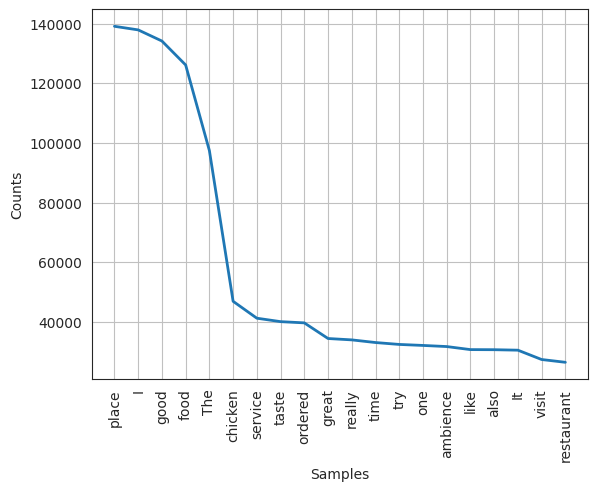

In [38]:
fd.plot(20)

# Bi-gram & Tri-gram analysis

In [39]:
bi_grams = bigrams(total_reviews_1D)
bi_grams

<generator object bigrams at 0x7f8c20378970>

In [40]:
fd_bigrams = FreqDist()

for bigram in bi_grams:
    fd_bigrams[bigram] = fd_bigrams[bigram] + 1
    
fd_bigrams.most_common(20)

[(('The', 'food'), 10497),
 (('I', 'ordered'), 10159),
 (('really', 'good'), 9575),
 (('This', 'place'), 8208),
 (('must', 'try'), 7824),
 (('I', 'would'), 7353),
 (('We', 'ordered'), 7223),
 (('visit', 'place'), 6897),
 (('food', 'good'), 6823),
 (('good', 'food'), 6482),
 (('The', 'place'), 6158),
 (('main', 'course'), 5544),
 (('non', 'veg'), 5364),
 (('good', 'place'), 5339),
 (('ice', 'cream'), 5287),
 (('also', 'good'), 5083),
 (('The', 'ambience'), 4798),
 (('I', 'tried'), 4523),
 (('good', 'I'), 4139),
 (('good', 'The'), 4078)]

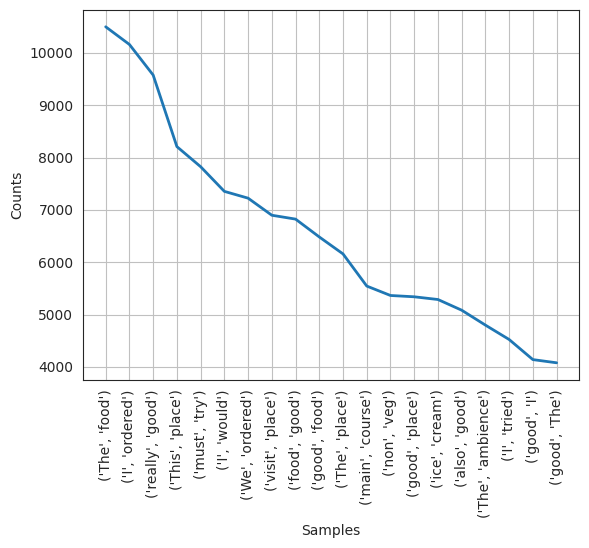

In [41]:
fd_bigrams.plot(20)

In [42]:
tri_grams = trigrams(total_reviews_1D)


fd_trigrams = FreqDist()

for trigram in tri_grams:
    fd_trigrams[trigram] = fd_trigrams[trigram] + 1
    
    
fd_trigrams.most_common(20)

[(('veg', 'non', 'veg'), 1525),
 (('must', 'visit', 'place'), 1487),
 (('The', 'food', 'good'), 1339),
 (('place', 'hangout', 'friends'), 1165),
 (('I', 'must', 'say'), 1131),
 (('I', 'would', 'recommend'), 1059),
 (('I', 'visited', 'place'), 1054),
 (('I', 'would', 'say'), 979),
 (('place', 'hang', 'friends'), 967),
 (('food', 'really', 'good'), 886),
 (('nFood', 'nAmbience', 'nService'), 845),
 (('A', 'must', 'visit'), 768),
 (('The', 'ambience', 'good'), 751),
 (('A', 'good', 'place'), 737),
 (('North', 'Indian', 'food'), 675),
 (('I', 'would', 'like'), 619),
 (('nFood', 'nService', 'nAmbience'), 607),
 (('A', 'must', 'try'), 603),
 (('I', 'really', 'liked'), 595),
 (('I', 'ordered', 'chicken'), 582)]

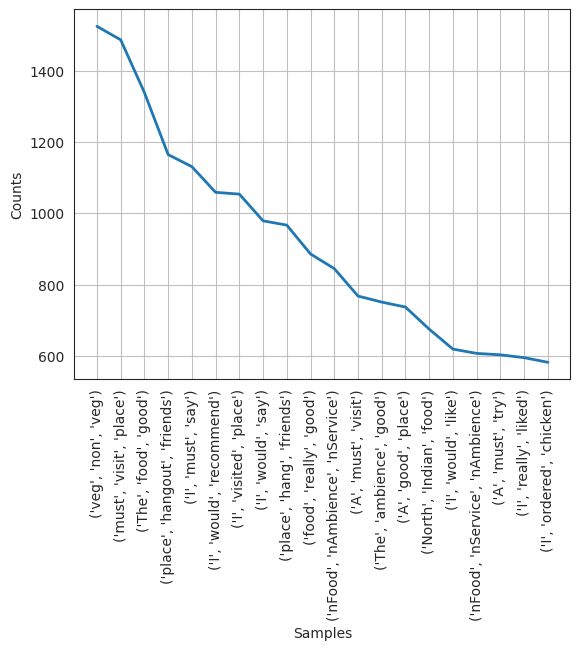

In [43]:
fd_trigrams.plot(20)

# Extracting Geographical coordinates

In [44]:
df.head(3)

,index,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari


In [45]:
df['location'].unique()

array(['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar',
       'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar',
       'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market',
       'Nagarbhavi', 'Bannerghatta Road', 'BTM', 'Kanakapura Road',
       'Bommanahalli', None, 'CV Raman Nagar', 'Electronic City', 'HSR',
       'Marathahalli', 'Sarjapur Road', 'Wilson Garden', 'Shanti Nagar',
       'Koramangala 5th Block', 'Koramangala 8th Block', 'Richmond Road',
       'Koramangala 7th Block', 'Jalahalli', 'Koramangala 4th Block',
       'Bellandur', 'Whitefield', 'East Bangalore', 'Old Airport Road',
       'Indiranagar', 'Koramangala 1st Block', 'Frazer Town', 'RT Nagar',
       'MG Road', 'Brigade Road', 'Lavelle Road', 'Church Street',
       'Ulsoor', 'Residency Road', 'Shivajinagar', 'Infantry Road',
       'St. Marks Road', 'Cunningham Road', 'Race Course Road',
       'Commercial Street', 'Vasanth Nagar', 'HBR Layout', 'Domlur',
       'Ejipura', 'Jeevan

In [46]:
len(df['location'].unique())

94

In [47]:
df['location'] = df['location'] + " , Bangalore , Karnataka , India"
df['location']

0             Banashankari , Bangalore , Karnataka , India
1             Banashankari , Bangalore , Karnataka , India
2             Banashankari , Bangalore , Karnataka , India
3             Banashankari , Bangalore , Karnataka , India
4             Basavanagudi , Bangalore , Karnataka , India
                               ...                        
51712           Whitefield , Bangalore , Karnataka , India
51713           Whitefield , Bangalore , Karnataka , India
51714           Whitefield , Bangalore , Karnataka , India
51715    ITPL Main Road, Whitefield , Bangalore , Karna...
51716    ITPL Main Road, Whitefield , Bangalore , Karna...
Name: location, Length: 51717, dtype: object

In [48]:
df_copy = df.copy()

In [49]:
df_copy['location'].isnull().sum()

21

In [50]:
df_copy = df_copy.dropna(subset = ['location'])


In [51]:
df_copy['location'].unique()

array(['Banashankari , Bangalore , Karnataka , India',
       'Basavanagudi , Bangalore , Karnataka , India',
       'Mysore Road , Bangalore , Karnataka , India',
       'Jayanagar , Bangalore , Karnataka , India',
       'Kumaraswamy Layout , Bangalore , Karnataka , India',
       'Rajarajeshwari Nagar , Bangalore , Karnataka , India',
       'Vijay Nagar , Bangalore , Karnataka , India',
       'Uttarahalli , Bangalore , Karnataka , India',
       'JP Nagar , Bangalore , Karnataka , India',
       'South Bangalore , Bangalore , Karnataka , India',
       'City Market , Bangalore , Karnataka , India',
       'Nagarbhavi , Bangalore , Karnataka , India',
       'Bannerghatta Road , Bangalore , Karnataka , India',
       'BTM , Bangalore , Karnataka , India',
       'Kanakapura Road , Bangalore , Karnataka , India',
       'Bommanahalli , Bangalore , Karnataka , India',
       'CV Raman Nagar , Bangalore , Karnataka , India',
       'Electronic City , Bangalore , Karnataka , India',
  

In [52]:
locations = pd.DataFrame(df['location'].unique())
locations.columns = ['name']
locations

,name
0,"Banashankari , Bangalore , Karnataka , India"
1,"Basavanagudi , Bangalore , Karnataka , India"
2,"Mysore Road , Bangalore , Karnataka , India"
3,"Jayanagar , Bangalore , Karnataka , India"
4,"Kumaraswamy Layout , Bangalore , Karnataka , I..."
...,...
89,"West Bangalore , Bangalore , Karnataka , India"
90,"Magadi Road , Bangalore , Karnataka , India"
91,"Yelahanka , Bangalore , Karnataka , India"
92,"Sahakara Nagar , Bangalore , Karnataka , India"


In [53]:
geolocator = Nominatim(user_agent = "app" , timeout=None)

lat = []
lon = []


for location in locations['name']:
    
    location = geolocator.geocode(location)
    if location is None:
        lat.append(np.nan)
        lon.append(np.nan)
    else:
        lat.append(location.latitude)
        lon.append(location.longitude)
        
        
locations['latitude'] = lat
locations['longitude'] = lon

locations

,name,latitude,longitude
0,"Banashankari , Bangalore , Karnataka , India",12.915219,77.573621
1,"Basavanagudi , Bangalore , Karnataka , India",12.941726,77.575502
2,"Mysore Road , Bangalore , Karnataka , India",12.946662,77.530090
3,"Jayanagar , Bangalore , Karnataka , India",12.929273,77.582423
4,"Kumaraswamy Layout , Bangalore , Karnataka , I...",12.908149,77.555318
...,...,...,...
89,"West Bangalore , Bangalore , Karnataka , India",13.022235,77.567183
90,"Magadi Road , Bangalore , Karnataka , India",12.975653,77.555355
91,"Yelahanka , Bangalore , Karnataka , India",13.100698,77.596345
92,"Sahakara Nagar , Bangalore , Karnataka , India",13.062147,77.580061


# Spatial analysis

In [54]:
locations.isnull().sum()

name         1
latitude     2
longitude    2
dtype: int64

In [55]:
locations['latitude'].isna()

0     False
1     False
2     False
3     False
4     False
      ...  
89    False
90    False
91    False
92    False
93    False
Name: latitude, Length: 94, dtype: bool

In [56]:
locations[locations['name'].isna()]


,name,latitude,longitude
16,NaN,46.314475,11.048029


In [57]:
locations['latitude'][80] = 13.0120218
locations['longitude'][80] = 77.6777817

In [58]:
locations['latitude'][86] = 13.010316
locations['longitude'][86] = 77.580569

In [59]:

locations

,name,latitude,longitude
0,"Banashankari , Bangalore , Karnataka , India",12.915219,77.573621
1,"Basavanagudi , Bangalore , Karnataka , India",12.941726,77.575502
2,"Mysore Road , Bangalore , Karnataka , India",12.946662,77.530090
3,"Jayanagar , Bangalore , Karnataka , India",12.929273,77.582423
4,"Kumaraswamy Layout , Bangalore , Karnataka , I...",12.908149,77.555318
...,...,...,...
89,"West Bangalore , Bangalore , Karnataka , India",13.022235,77.567183
90,"Magadi Road , Bangalore , Karnataka , India",12.975653,77.555355
91,"Yelahanka , Bangalore , Karnataka , India",13.100698,77.596345
92,"Sahakara Nagar , Bangalore , Karnataka , India",13.062147,77.580061


In [60]:
df['cuisines'].isnull().sum()

45

In [61]:
df=df.dropna(subset=['cuisines'])

In [62]:
north_india= df[df['cuisines'].str.contains('North Indian')]
north_india_rest_count = north_india['location'].value_counts().reset_index().rename(columns= {'location' : 'name'})
north_india_rest_count

,name,count
0,"BTM , Bangalore , Karnataka , India",2469
1,"HSR , Bangalore , Karnataka , India",1123
2,"Whitefield , Bangalore , Karnataka , India",1059
3,"Marathahalli , Bangalore , Karnataka , India",1038
4,"JP Nagar , Bangalore , Karnataka , India",958
...,...,...
85,"Hebbal , Bangalore , Karnataka , India",4
86,"Jakkur , Bangalore , Karnataka , India",3
87,"Central Bangalore , Bangalore , Karnataka , India",2
88,"West Bangalore , Bangalore , Karnataka , India",1


In [63]:
heat_map_df= north_india_rest_count.merge(locations, on = 'name' , how = 'left')
heat_map_df

,name,count,latitude,longitude
0,"BTM , Bangalore , Karnataka , India",2469,12.911276,77.604565
1,"HSR , Bangalore , Karnataka , India",1123,12.911623,77.638862
2,"Whitefield , Bangalore , Karnataka , India",1059,12.969637,77.749745
3,"Marathahalli , Bangalore , Karnataka , India",1038,12.955257,77.698416
4,"JP Nagar , Bangalore , Karnataka , India",958,12.912264,77.590457
...,...,...,...,...
85,"Hebbal , Bangalore , Karnataka , India",4,13.038218,77.591900
86,"Jakkur , Bangalore , Karnataka , India",3,13.078474,77.606894
87,"Central Bangalore , Bangalore , Karnataka , India",2,12.974540,77.530737
88,"West Bangalore , Bangalore , Karnataka , India",1,13.022235,77.567183


In [64]:
basemap= folium.Map() 
basemap

In [65]:
heat_map_df.columns

Index(['name', 'count', 'latitude', 'longitude'], dtype='object')

In [66]:
HeatMap(heat_map_df[['latitude', 'longitude' , 'count']]).add_to(basemap)

In [67]:
basemap